In [2]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns 
import statsmodels.stats.proportion as proportion
from scipy.stats import ttest_ind,mannwhitneyu,shapiro,norm
from statsmodels.stats.weightstats import ztest
from tqdm import tqdm
import timeit
from scipy import stats
import math
from datetime import date, datetime, timedelta
import time
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
import warnings
warnings.filterwarnings("ignore")
import clickhouse_connect  



from credential import postgres_secret,clickhouse_dwh_secret

def get_engine(user):
    if user == postgres_secret['user']:
        db_name = postgres_secret['db_name']
        password = postgres_secret['password']
        host = postgres_secret['host']
        engine = create_engine(f'postgresql://{user}:{password}@{host}:6432/{db_name}')
    elif user == clickhouse_dwh_secret['user']:
            db_name = clickhouse_dwh_secret['db_name'] 
            password = clickhouse_dwh_secret['password']
            host = clickhouse_dwh_secret['host']
            engine = create_engine(f'clickhouse://{user}:{password}@{host}:8123/{db_name}')
    return engine
    
connection_clickhouse = clickhouse_connect.get_client(
    host = clickhouse_dwh_secret['host'],
    port= '8123',
    username = clickhouse_dwh_secret['user'],
    password = clickhouse_dwh_secret['password'],
    database='datamarts'
    )

    
def execute(SQL, user):
    start_time = time.time()  # запоминаем время начала выполнения функции
    engine = get_engine(user)
    Session = sessionmaker(bind=engine)  # sessions factory ()
    with Session() as session: # open session
        result = session.execute(text(SQL))
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
        
    end_time = time.time()  # запоминаем время окончания выполнения функции
    execution_time = round(end_time - start_time,4) # вычисляем время выполнения   
    
    print(f"Время выполнения функции: {execution_time} секунд")
    print()
    return df

In [9]:
query = f'''
WITH first_step AS (
    SELECT date,
        utc_timestamp,
        profile_id,
        user_id,
        client_type,
        event_name,
        event_page,
        payload,
        bonus_title,
        app_version,
        app_version,
        session_id,
        created_at::date AS trial_start,
        free_days,
        device_type,
        os_version,
        reg_date,
        trial_start+free_days AS trial_end,
        source,
        promo_type,
        first_prolong_date::date AS first_prolong_date,
        ends_at,
        country
    FROM 
        datamarts.clean_event
    WHERE 
        date>='2024-11-01'
        AND reg_date!='1970-01-01' 
        AND client_type!='backend'
),

second_step AS (
    SELECT
        date,
        utc_timestamp,
        user_id,
        profile_id,
        client_type,
        bonus_title,
        event_name,
        event_page,
        session_id,
        reg_date,
        app_version,
        country,
        trial_start,
        trial_end,
        promo_type,
        first_prolong_date,
        ends_at,
        source,
        free_days,
        device_type,
        os_version,
        event_name,
        CASE WHEN first_prolong_date!='1970-01-01' 
                AND date>=first_prolong_date 
                AND ends_at>=date THEN 'subs'
                WHEN date>=trial_start 
                AND ends_at>=date (first_prolong_date='1970-01-01' OR first_prolong_date>date) THEN 'trial'
                WHEN date>=reg_date 
                AND (trial_start='1970-01-01' OR trial_start>date) THEN 'reg'
        END AS user_type,
        JSONExtractInt(payload,'duration') AS duration,
        JSONExtractString(payload,'item_type') AS item_type,
        JSONExtractString(payload,'item_title') AS item_title,
        JSONExtractString(payload,'season') AS item_season,
        JSONExtractString(payload,'episode') AS item_episode,
        CASE WHEN event_name IN ('auto_player_streaming','auto_kinom_streaming') 
                AND event_page<>'tvchannel' 
                AND JSONExtractInt(payload,'viewing_time')<= JSONExtractInt(payload,'duration')
                THEN JSONExtractInt(payload,'viewing_time')
                WHEN event_name IN ('auto_player_streaming','auto_kinom_streaming') 
                AND event_page='tvchannel' 
                AND JSONExtractInt(payload,'viewing_time') <18000
                THEN JSONExtractInt(payload,'viewing_time')
        END AS viewing_time,
        count(DISTINCT item_title) OVER (PARTITION BY date,profile_id) AS viewing_cnt,
        uniq(session_id) OVER (PARTITION BY date,profile_id) as session_cnt_ttl,
        sum(viewing_time) OVER (PARTITION BY date,profile_id,item_title) AS viewing_time_per_item
    FROM
        first_step
),

third_step AS (
    SELECT 
        date,
        profile_id,
        client_type,
        promo_type,
        CASE WHEN promo_type='cards' THEN 'b2b' ELSE 'b2c' END AS b2c_b2b,
        bonus_title,
        source,
        CASE WHEN item_type LIKE '' THEN 'kinom'
                WHEN item_type IN ('series','movie','tvchannel') THEN item_type
                ELSE 'other'
        END AS item_type,
        item_title,
        duration,
        session_id,
        user_type,
        free_days,
        session_cnt_ttl,
        app_version,
        country,
        device_type,
        os_version,
        uniq(session_id) AS session_cnt,
        sum(viewing_time) AS watchtime
    FROM
        second_step 
    GROUP BY
        1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
),

--SELECT * FROM third_step
--WHERE date='2025-01-23' AND profile_id='4eeb561a-b7bf-4a13-87c0-8819a809e3c1'


fourth_step AS (
    SELECT
        date,
        client_type,
        CASE WHEN app_version like '%sber%' THEN 'sber_device' 
                WHEN app_version not like '%sber%' AND client_type='android_tv' THEN 'android_tv (without sber)' 
                ELSE client_type 
            END AS client_type_w_sberdevice,
        profile_id,
        b2c_b2b,
        promo_type,
        session_cnt_ttl,
        session_cnt,
        app_version,
        country,
        item_type,
        session_id,
        bonus_title,
        source,
        user_type,
        free_days,
        device_type,
        os_version,
        CASE WHEN item_type='kinom' AND duration>0 AND watchtime>=30 THEN 1
                WHEN item_type='tvchannel' AND watchtime>=30 THEN 1
                WHEN item_type='series' AND duration>600 AND watchtime>=duration*0.05 THEN 1
                WHEN item_type='movie' AND duration>600 AND watchtime>=duration*0.05 THEN  1
                ELSE 0
        END AS watch_session,
        CASE	WHEN item_type='tvchannel' AND watchtime>=30 THEN 1
                WHEN item_type='series' AND duration>600 AND watchtime>=duration*0.05 THEN 1
                WHEN item_type='movie' AND duration>600 AND watchtime>=duration*0.05 THEN  1
                ELSE 0
        END AS watch_session_2,
        watchtime,
        uniq(CASE WHEN watch_session=1 THEN session_id END) OVER (PARTITION BY date,profile_id) AS session_watch_ttl
    FROM
        third_step
)

SELECT 
    date,
    profile_id,
    client_type,
    client_type_w_sberdevice,
    bonus_title,
    source,
    item_type,
    b2c_b2b,
    user_type,
    free_days,
    app_version,
    promo_type,
    country,
    device_type,
    os_version,
    session_cnt_ttl,
    session_watch_ttl,
    uniq(CASE WHEN watch_session=1 THEN session_id END) AS session_watch,
    uniq(CASE WHEN watch_session_2=1 THEN session_id END) AS session_watch_2,
    COALESCE(sum(CASE WHEN watch_session=1 THEN watchtime END),0) AS watchtime_session_watch,
    COALESCE(sum(CASE WHEN watch_session_2=1 THEN watchtime END),0) AS watchtime_session_watch_2,
    uniq(session_cnt) AS session_cnt2,
    COALESCE(sum(watchtime),0) AS watchtime2
FROM
    fourth_step
GROUP BY
    1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
;


'''
    
    
df = execute(query,user = 'kmekhtiev')

Время выполнения функции: 59.827 секунд



In [53]:
df_agg = df.groupby('date',as_index=False)[['watchtime_session_watch','watchtime_session_watch_2','watchtime2']]\
            .sum()\
            .rename(columns={'watchtime_session_watch':'qualified_watchtime','watchtime_session_watch_2':'qualified_watchtime_wo_kinom','watchtime2':'watchtime'})

In [187]:
df_uniq_all = df.groupby('date',as_index=False).agg('profile_id').nunique().rename(columns={'profile_id':'all_user'})
df_uniq_qualified= df[df['session_watch']>=1].groupby('date',as_index=False).agg('profile_id').nunique().rename(columns={'profile_id':'user_qualified_watchtime'})
df_uniq_qualified_wo_kinom = df[df['session_watch_2']>=1].groupby('date',as_index=False).agg('profile_id').nunique().rename(columns={'profile_id':'user_qualified_watchtime_wo_kinom'})


df_agg_ttl = pd.merge(df_agg,df_uniq_all,how='left',on='date')
df_agg_ttl = pd.merge(df_agg_ttl,df_uniq_qualified,how='left',on='date')
df_agg_ttl = pd.merge(df_agg_ttl,df_uniq_qualified_wo_kinom,how='left',on='date')

df_agg_ttl['WPU'] = df_agg_ttl['watchtime']/df_agg_ttl['all_user']/60
df_agg_ttl['WPWU'] = df_agg_ttl['qualified_watchtime']/df_agg_ttl['user_qualified_watchtime']/60
df_agg_ttl['WPWU_wo_kinom'] = df_agg_ttl['qualified_watchtime_wo_kinom']/df_agg_ttl['user_qualified_watchtime_wo_kinom']/60

df_agg_ttl

,date,qualified_watchtime,qualified_watchtime_wo_kinom,watchtime,all_user,user_qualified_watchtime,user_qualified_watchtime_wo_kinom,WPU,WPWU,WPWU_wo_kinom
0,2024-11-01,2911850,2862729,2965486,2542,700,529,19.443260,69.329762,90.193100
1,2024-11-02,2760733,2724849,2821257,2678,719,527,17.558234,63.994738,86.174858
2,2024-11-03,3443066,3401863,3510028,2832,785,585,20.656944,73.101189,96.919174
3,2024-11-04,3126978,3093248,3189266,2718,772,589,19.556451,67.508161,87.528240
4,2024-11-05,2632643,2583127,2686955,2534,669,506,17.672685,65.586522,85.083235
...,...,...,...,...,...,...,...,...,...,...
89,2025-01-29,3471867,3411781,3547808,3205,935,703,18.449340,61.887112,80.886226
90,2025-01-30,3520106,3458001,3579735,2928,927,724,20.376452,63.288493,79.604075
91,2025-01-31,3711720,3618166,3782000,3170,961,732,19.884332,64.372529,82.380829
92,2025-02-01,4084805,3995715,4170024,3390,1052,809,20.501593,64.714908,82.317985


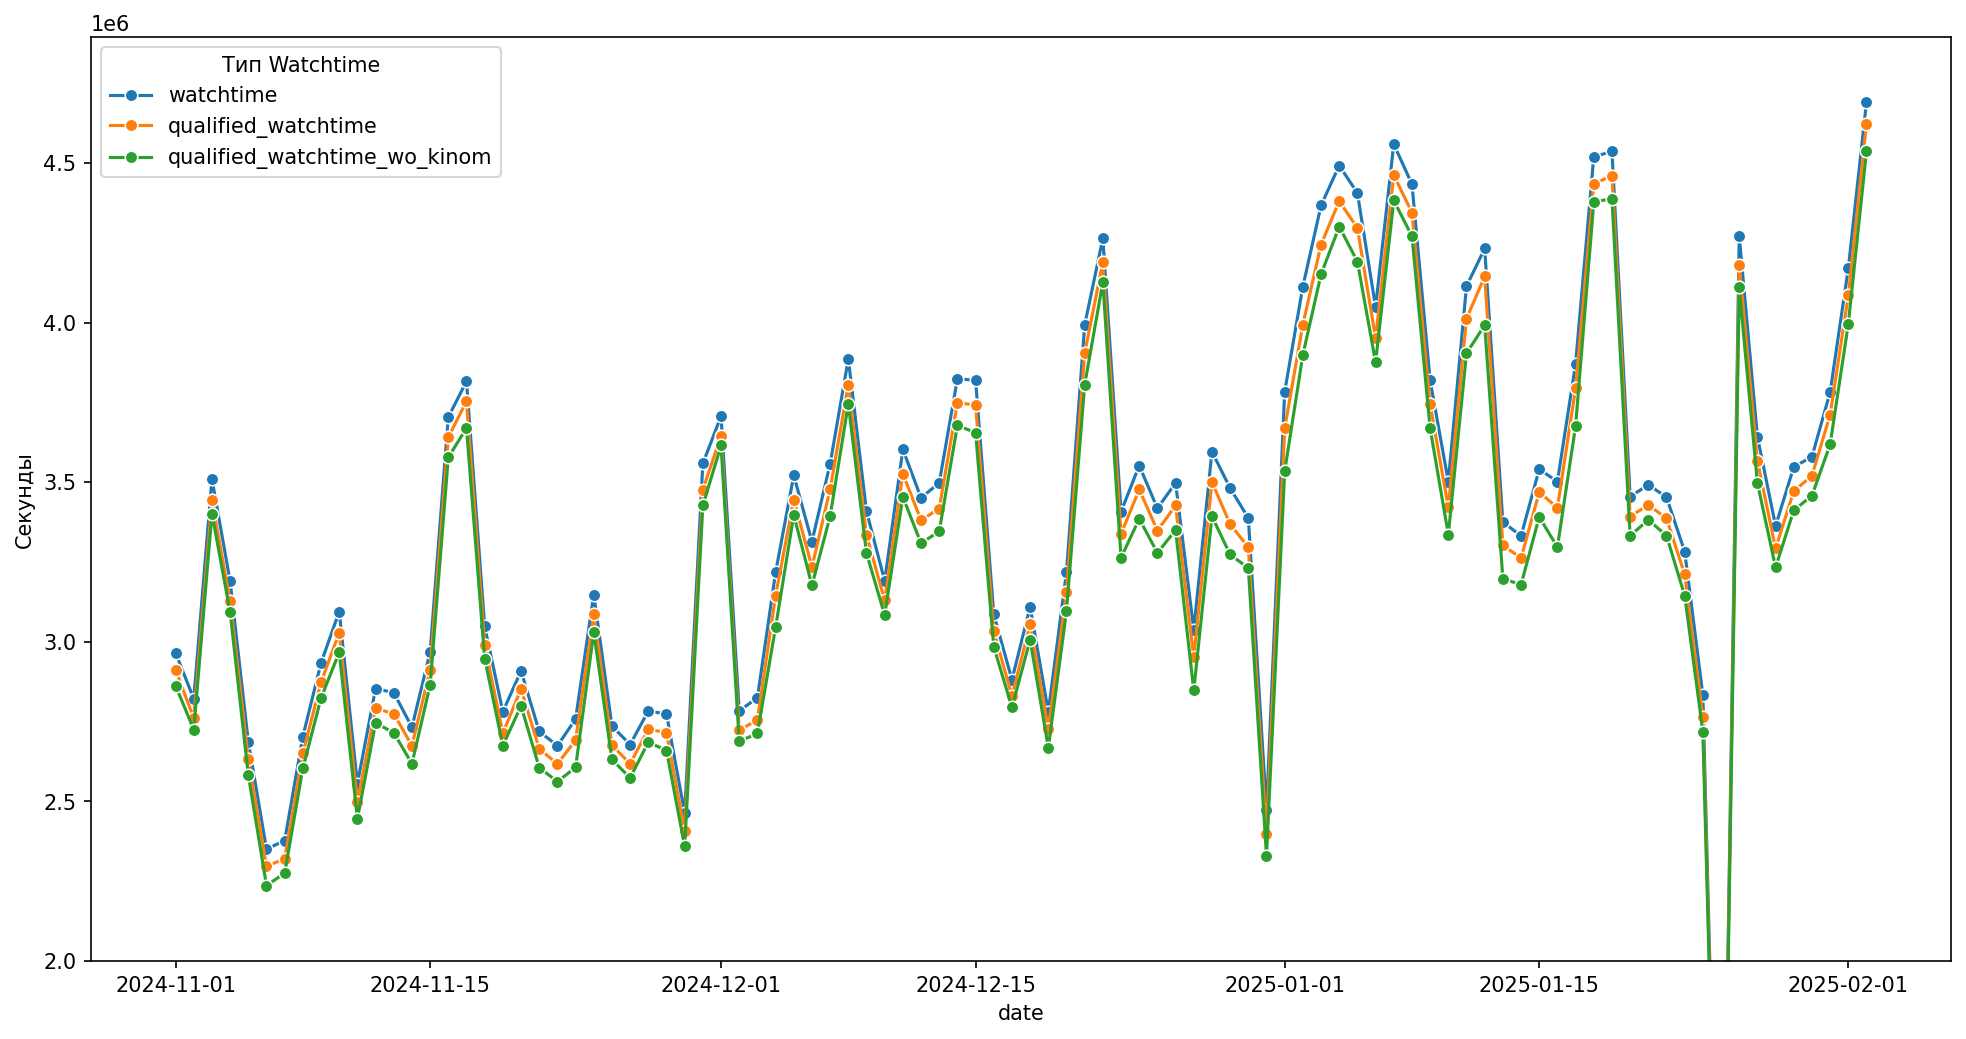

In [197]:
plt.figure(figsize=(16,8),dpi=150)

sns.lineplot(data=df_agg_ttl,x='date',y='watchtime',marker='o',label='watchtime')
sns.lineplot(data=df_agg_ttl,x='date',y='qualified_watchtime',marker='o',label='qualified_watchtime')
sns.lineplot(data=df_agg_ttl,x='date',y='qualified_watchtime_wo_kinom',marker='o',label='qualified_watchtime_wo_kinom')
plt.legend(title='Тип Watchtime')
plt.ylabel('Секунды')
plt.ylim(2000000)
plt.show()

In [181]:
df_agg_ttl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   date                               94 non-null     object 
 1   qualified_watchtime                94 non-null     int64  
 2   qualified_watchtime_wo_kinom       94 non-null     int64  
 3   watchtime                          94 non-null     int64  
 4   all_user                           94 non-null     int64  
 5   user_qualified_watchtime           94 non-null     int64  
 6   user_qualified_watchtime_wo_kinom  94 non-null     int64  
 7   WPU                                94 non-null     float64
 8   WPWU                               94 non-null     float64
 9   WPWU_wo_kinom                      94 non-null     float64
dtypes: float64(3), int64(6), object(1)
memory usage: 7.5+ KB


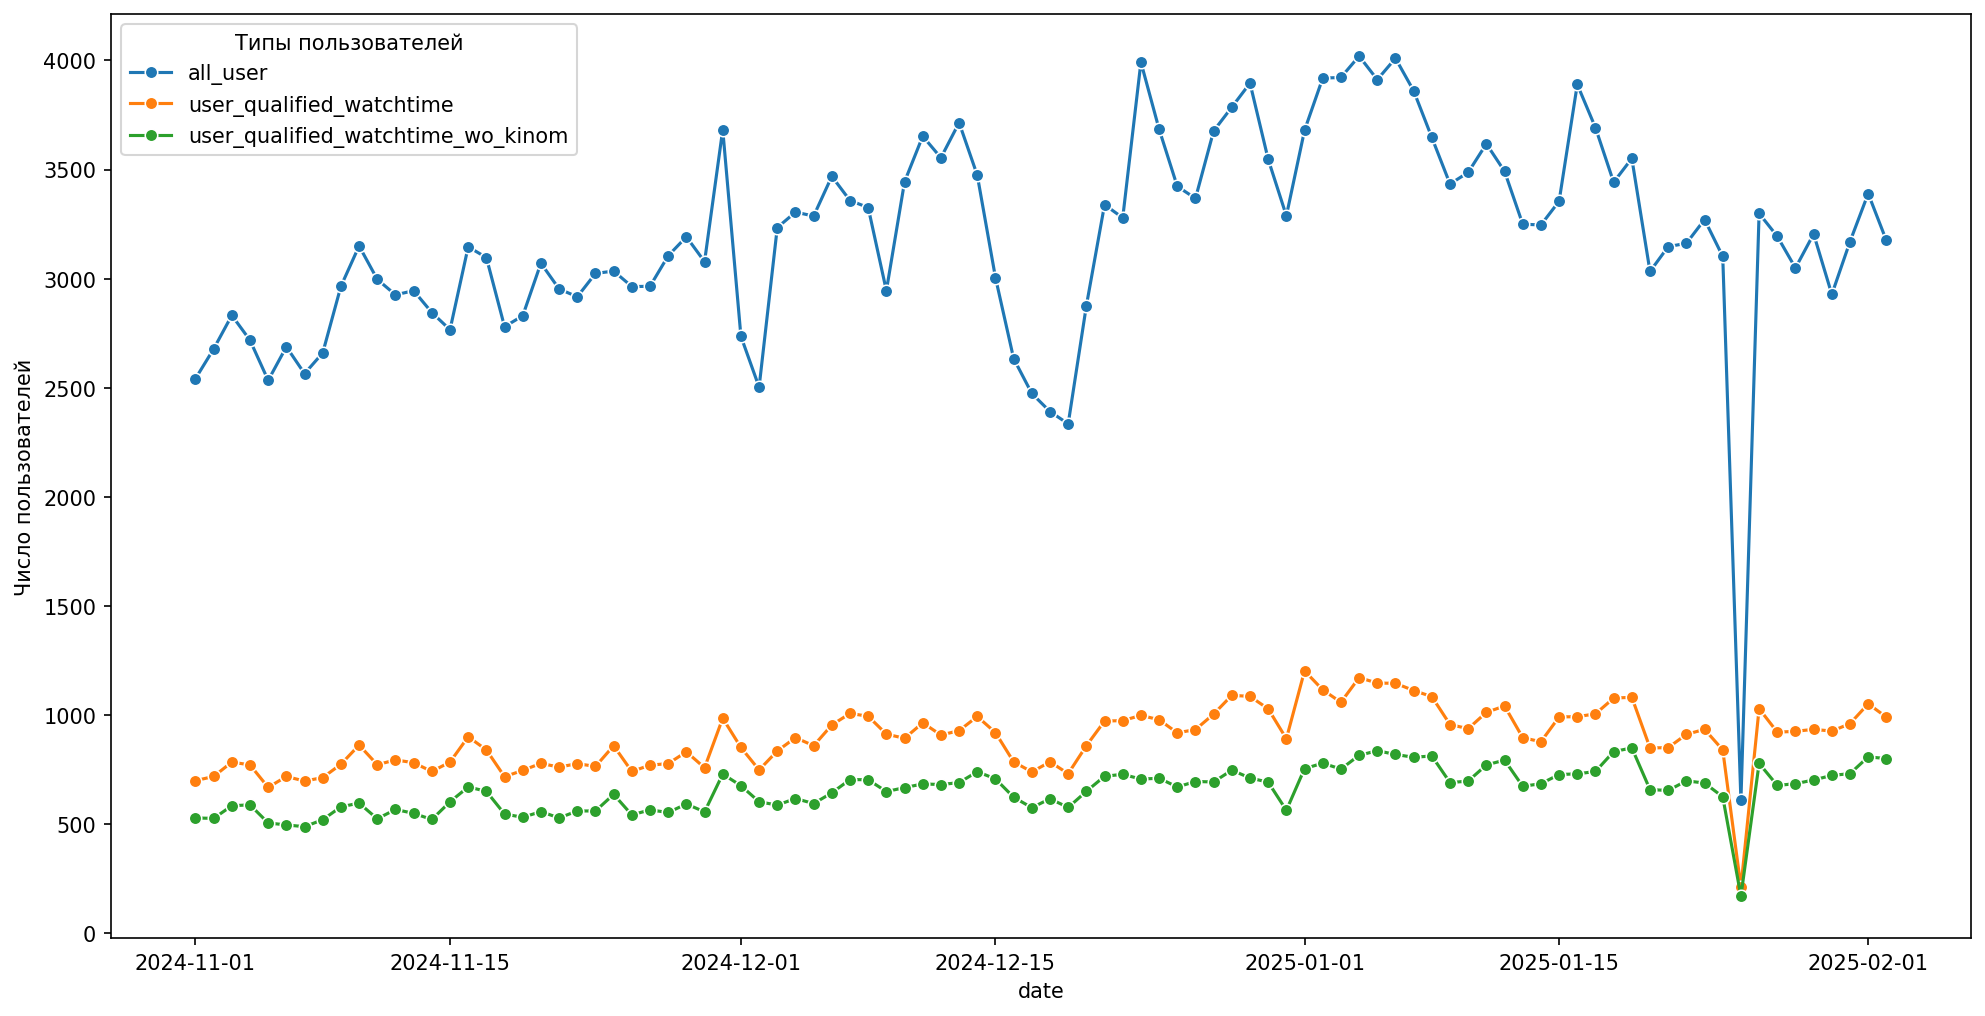

In [199]:
plt.figure(figsize=(16,8),dpi=150)

sns.lineplot(data=df_agg_ttl,x='date',y='all_user',marker='o',label='all_user')
sns.lineplot(data=df_agg_ttl,x='date',y='user_qualified_watchtime',marker='o',label='user_qualified_watchtime')
sns.lineplot(data=df_agg_ttl,x='date',y='user_qualified_watchtime_wo_kinom',marker='o',label='user_qualified_watchtime_wo_kinom')
plt.legend(title='Типы пользователей')
plt.ylabel('Число пользователей')

plt.show()

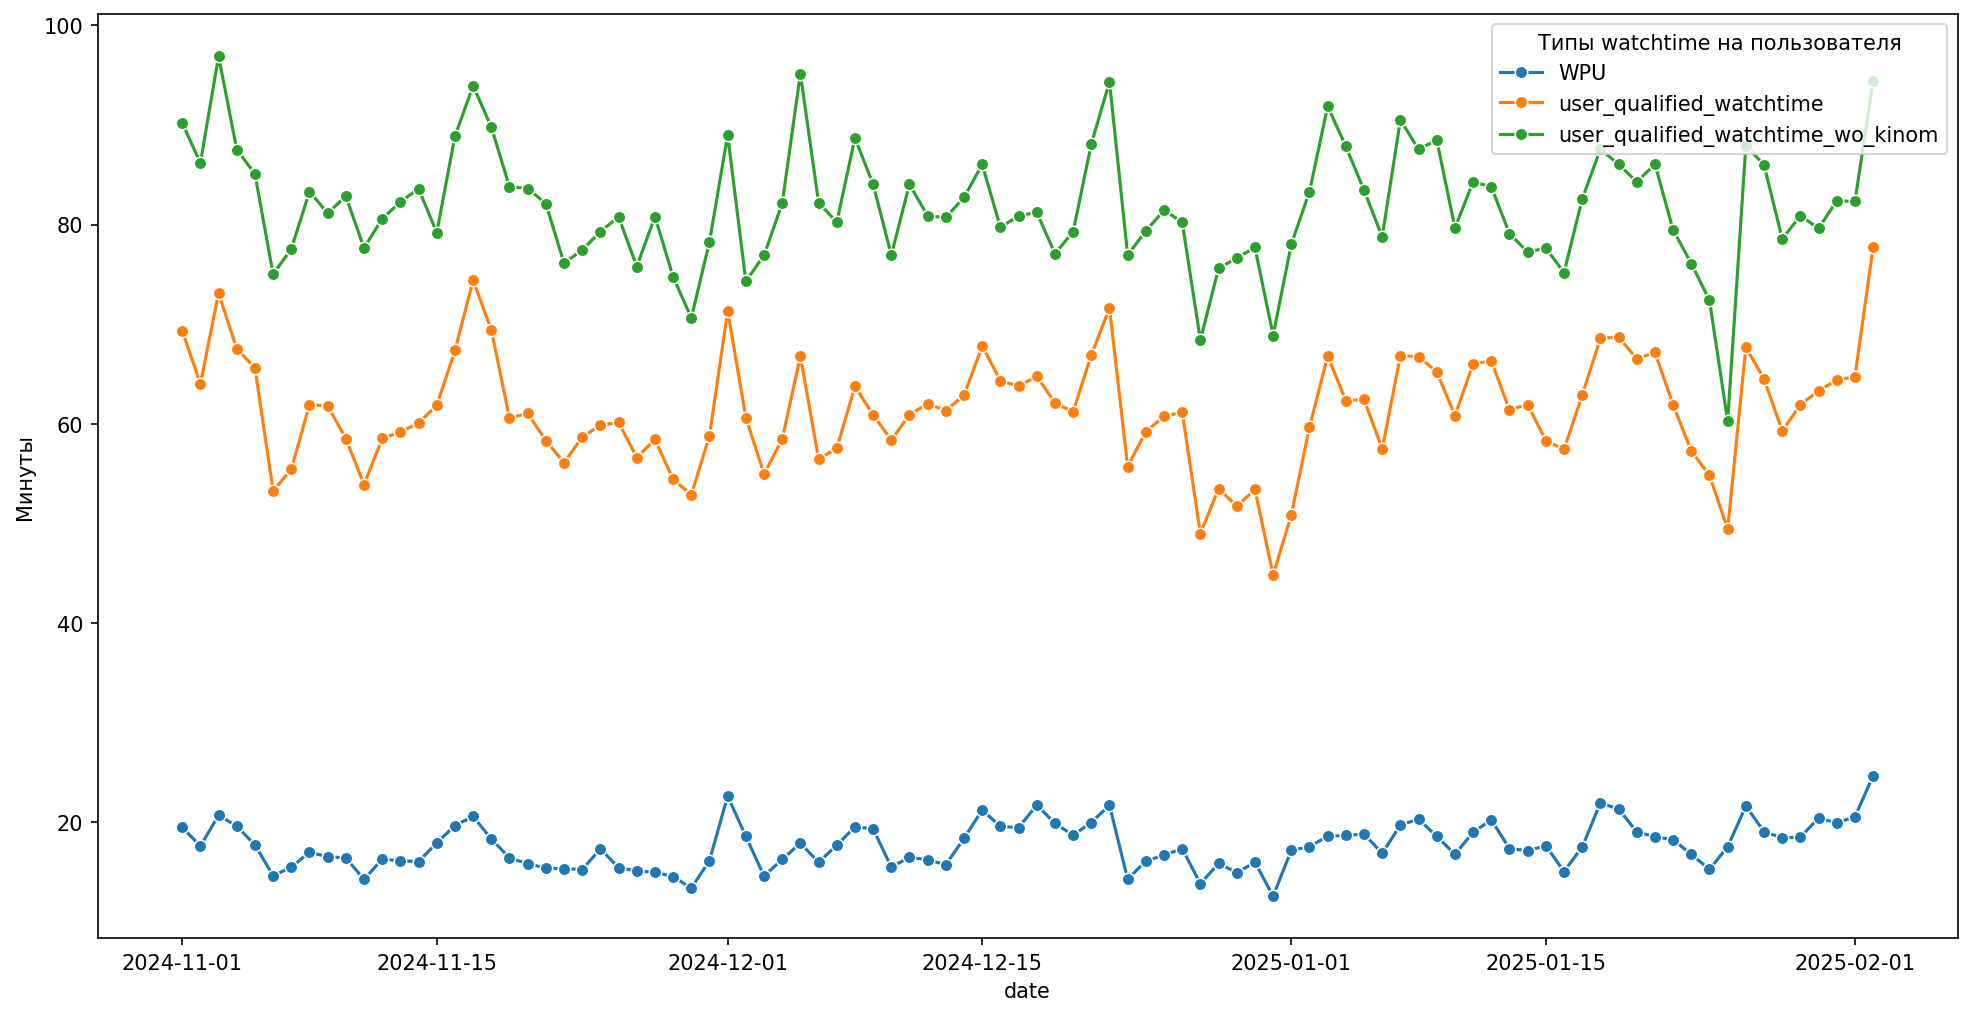

In [201]:
plt.figure(figsize=(16,8),dpi=150)

sns.lineplot(data=df_agg_ttl,x='date',y='WPU',marker='o',label='WPU')
sns.lineplot(data=df_agg_ttl,x='date',y='WPWU',marker='o',label='user_qualified_watchtime')
sns.lineplot(data=df_agg_ttl,x='date',y='WPWU_wo_kinom',marker='o',label='user_qualified_watchtime_wo_kinom')
plt.legend(title='Типы watchtime на пользователя')
plt.ylabel('Минуты')
plt.show()

In [213]:
df.groupby('date',as_index=False)[['watchtime_session_watch','watchtime_session_watch_2','watchtime2']].std()

,date,watchtime_session_watch,watchtime_session_watch_2,watchtime2
0,2024-11-01,2540.365479,2536.316814,2542.902776
1,2024-11-02,2450.827895,2451.524772,2453.422763
2,2024-11-03,3092.096563,3092.649130,3093.109608
3,2024-11-04,2692.058617,2692.371260,2694.627397
4,2024-11-05,2407.633426,2402.614101,2408.549147
...,...,...,...,...
89,2025-01-29,2524.832824,2523.809343,2529.483959
90,2025-01-30,2578.176132,2577.554174,2582.144830
91,2025-01-31,2567.067537,2559.178481,2569.929562
92,2025-02-01,2664.996633,2657.467854,2668.645577


In [243]:
df[['watchtime_session_watch','watchtime_session_watch_2','watchtime2']].std()

watchtime_session_watch      2524.506893
watchtime_session_watch_2    2517.024691
watchtime2                   2527.983934
dtype: float64

## Посмотрим конверсию в вэбе в качественное смотрение

In [375]:
# Здесь смотрим подневную динамику и берем среднее (не лучшее решение)

ttl = df[df['client_type'].isin(['web_desktop','web_mobile'])].groupby('date',as_index=False)['profile_id'].nunique()
qual = df[(df['client_type'].isin(['web_desktop','web_mobile'])) & (df['session_watch']>=1)].groupby('date',as_index=False)['profile_id'].nunique()

ttl_2 = pd.merge(ttl,qual,how='left',on='date',suffixes=('_all','_qualifaied'))

print(f'Среднеквартальная конверсия в квалифицированное смотрение:',(ttl_2['profile_id_qualifaied']/ttl_2['profile_id_all']).mean())

Среднеквартальная конверсия в квалифицированное смотрение: 0.19212304762474447


In [377]:
#Считаем конверсию как уникальное число зарегов, кто заходил и уникальное число пользователей, у кого было смотрение
ttl = df[df['client_type'].isin(['web_desktop','web_mobile'])]['profile_id'].nunique()
qual = df[(df['client_type'].isin(['web_desktop','web_mobile'])) & (df['session_watch']>=1)]['profile_id'].nunique()

print(qual/ttl)


0.14703580109586784


In [379]:
#Считаем конверсию как уникальное число зарегов, кто заходил и уникальное число пользователей, у кого было смотрение
ttl = df[(df['client_type'].isin(['web_desktop','web_mobile'])) & (df['watchtime2']>0)]['profile_id'].nunique()
qual = df[(df['client_type'].isin(['web_desktop','web_mobile'])) & (df['session_watch']>=1)]['profile_id'].nunique()

print(qual/ttl)


0.3781120881449306


In [301]:
df[(df['date']>='2024-10-01') & (df['date']<='2024-12-31')].groupby('date')['profile_id'].nunique().reset_inded()

,date,profile_id
0,2024-11-01,2542
1,2024-11-02,2678
2,2024-11-03,2832
3,2024-11-04,2718
4,2024-11-05,2534
...,...,...
56,2024-12-27,3677
57,2024-12-28,3786
58,2024-12-29,3896
59,2024-12-30,3547


In [217]:
query=f''' SELECT * FROM datamarts.watchtime_by_day WHERE date>='2024-11-01' '''
df_2 = execute(query,user='kmekhtiev')

df_2

Время выполнения функции: 7.9452 секунд



,date,profile_id,client_type,client_type_w_sberdevice,bonus_title,source,item_type,b2c_b2b,user_type,free_days,app_version,promo_type,country,session_cnt_ttl,session_watch_ttl,session_watch,watchtime_session_watch,session_cnt,watchtime
0,2025-01-30,68daba0c-1104-49eb-baaf-8d37272f95c7,android_tv,android_tv (without sber),Яндекс Директ. 1 месяц - за 1 рубль.,,kinom,b2c,trial,30,2.10-prod-yandex,promo,ru,1,0,0,0,1,0
1,2025-01-30,5f27cfb8-6134-4c9a-86ad-3772b4f40663,web_desktop,web_desktop,,flocktory,kinom,b2c,reg,0,4.14.0-prod,no_promo,ru,1,0,0,0,1,0
2,2025-01-30,82834e7b-5f1f-47ff-806b-6963c6a0d101,web_desktop,web_desktop,,,kinom,b2c,reg,0,4.14.0-prod,no_promo,ru,2,0,0,0,1,7
3,2025-01-30,b39b51c9-d1f7-468f-bdec-62b48b9f04e2,android,android,,,kinom,b2c,reg,0,2.58-prod_am,no_promo,am,1,0,0,0,1,0
4,2025-01-30,1000f35a-ecf9-4246-b4ca-00d10674b4b1,android,android,,,kinom,b2c,reg,0,,no_promo,ru,3,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631669,2025-01-22,efb2c1c4-c897-4f98-b8b1-12dee8105946,ios,ios,,,kinom,b2c,reg,0,2.3.4-prod,no_promo,ru,2,1,1,285,1,285
631670,2025-01-22,3a792288-c81d-4f65-92f0-c5c96138350a,android_tv,android_tv (without sber),Flocktory: Exchange 365 (3&399) ver 2,,kinom,b2c,trial,35,2.10-prod-androidtv,promo,ru,3,1,0,0,1,0
631671,2025-01-22,eb439ac1-ee3e-4b33-bbf4-be29ae6f6cac,smart_tv,smart_tv,,,movie,b2c,subs,3,3.2.3-prod-modern,no_promo,ru,3,2,0,0,1,0
631672,2025-01-22,bf907f27-179d-4fc1-8dcd-906d290589b1,ios,ios,,,series,b2c,subs,14,2.3.4-prod,no_promo,ru,1,1,1,889,1,889


In [235]:
np.std([df['watchtime_session_watch']])

2524.504893278072